# Electricity Loads Analysis

## Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from tslearn.clustering import TimeSeriesKMeans
from sklearn.neighbors import NearestNeighbors
from scipy import signal
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Preparation

### Data Preparation

In [4]:
# Import Data
data = pd.read_csv("../Data/LD2011_2014.txt", delimiter=";", low_memory=False)
data.to_csv("../Data/LD2011_2014.csv", index=None)

# Data Preparation
data.rename(columns={'Unnamed: 0':"datetime"}, inplace=True)
# First Column: str -> datatime
data['datetime'] = pd.to_datetime(data['datetime'])

# All other columns: str -> float
data = data.replace(",", ".", regex=True)
data[data.columns[1:]] = data[data.columns[1:]].astype('float')

# Drop Duplicates
data.drop_duplicates(subset=['datetime'], inplace=True) 

# Search for values < 0
if (True in (data[data.columns[1:]].values < 0)):
    print('There are values less than zero')
else:
    print('Only positive and zero values')

# Search for null values
if (data.isnull().values.any()):
    print('There are null values.')
else:
    print('There are no null values.')

# Convert kW to kWh
data[data.columns[1:]] = data[data.columns[1:]]/4

data.to_csv("../Data/AP_LD2011_2014.csv", index=False)

Only positive and zero values
There are no null values.


### Import AP(After Preparation) Dataset

In [5]:
# Import Data
data = pd.read_csv("../Data/AP_LD2011_2014.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data_with_datetime_index=data.set_index('datetime')

## Visualisation


### Distribution of consumption values in the Dataset

In [6]:
# Create a pd.Series object of all dataset values
series_list =[]
for i in data[data.columns[1:]]:
    series_list.append(data[i])

d = pd.concat(series_list).reset_index(drop=True)

Entire Dataset


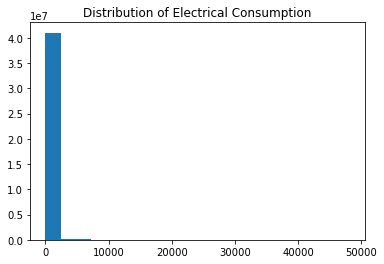


Values between 0 and 300


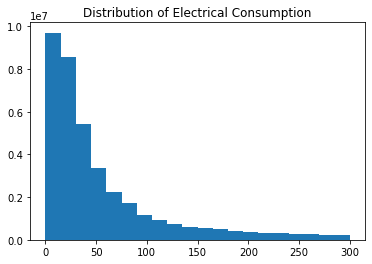


So schematically we understand that the distribution of values follows the function 1÷x, where x > 0


In [7]:
def print_distribution(i, j):
    plt.hist(d[(d>i) & (d<j)], bins=20)
    plt.title('Distribution of Electrical Consumption')
    plt.show()

print("Entire Dataset")
print_distribution(0,len(d))
print("\nValues between 0 and 300")
print_distribution(0, 300)
print('\nSo schematically we understand that the distribution of values follows the function 1÷x, where x > 0')

### Electrical Consumption per Customer (kWh): Min | Mean | Max 

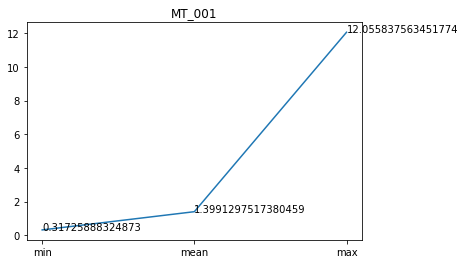

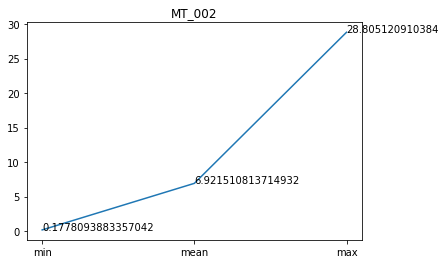

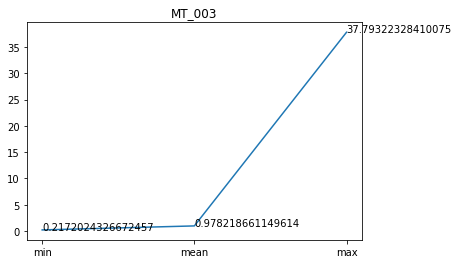

In [8]:
# Create a Customer Consumption Dataframe
customer_consumption=[]

for i in data.columns[1:]:
    customer=data[i]
    customer_consumption.append([i, customer[customer > 0].min(), customer[customer > 0].mean(), customer[customer > 0].max()])

customer_consumption=pd.DataFrame(customer_consumption, columns=['customer_id', 'min', 'mean', 'max'])

# Display plot per Customer
for i in range(3):
    x=customer_consumption.columns[1:]
    y=customer_consumption[customer_consumption.columns[1:]].iloc[i].tolist()
    plt.plot(x, y)
    plt.title(customer_consumption['customer_id'].iloc[i])
    for index in range(len(x)):
        plt.text(x[index], y[index], y[index], size=10)
    plt.show()

### Trending Analysis for the first 3 consumers




MT_001


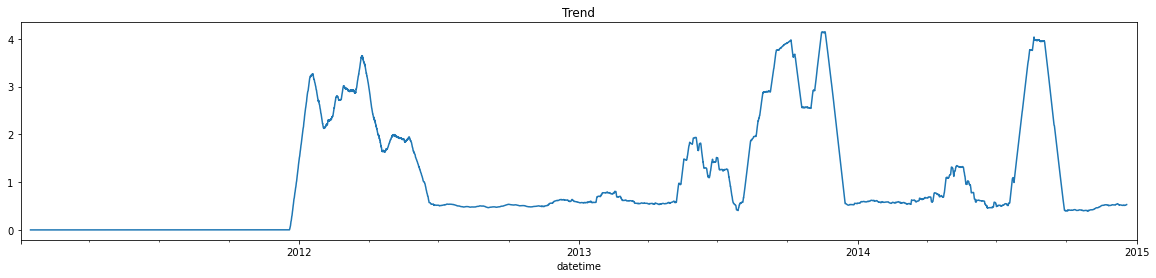

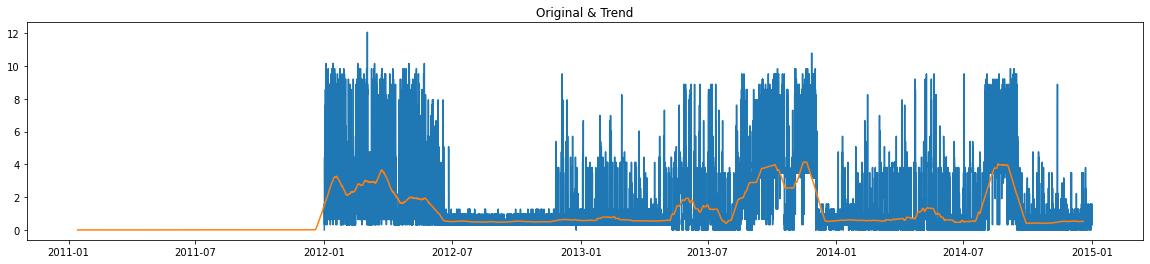




MT_002


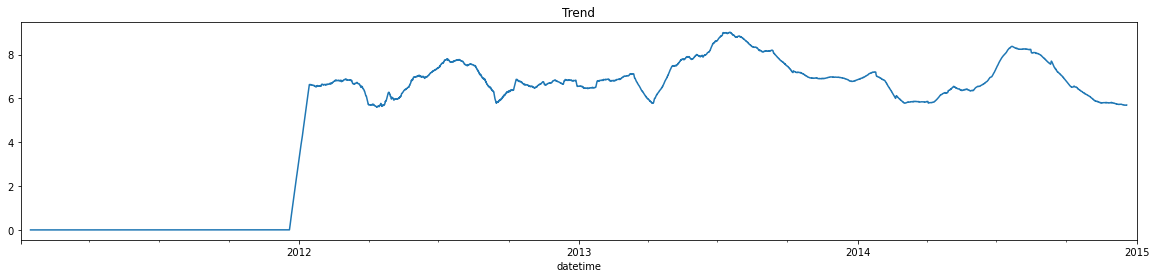

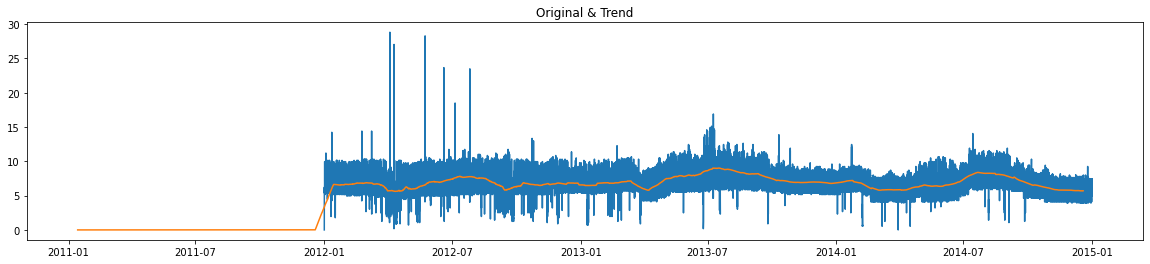




MT_003


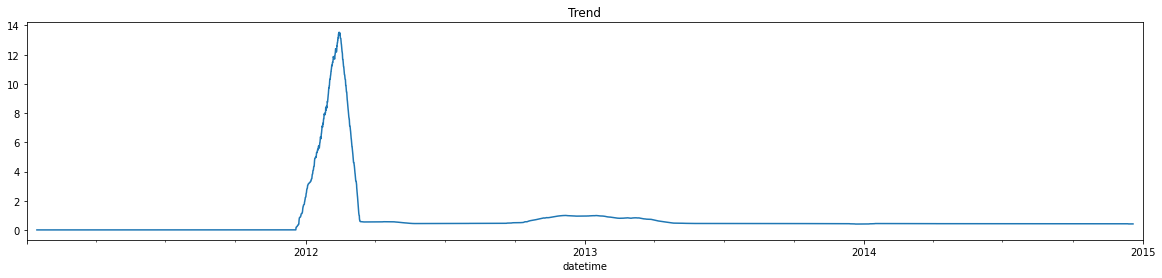

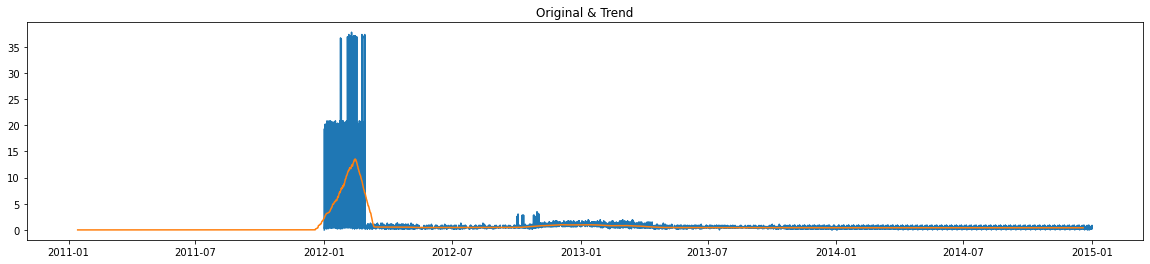

In [9]:
# Trending
for i in data_with_datetime_index.columns[:3]:
    print("\n\n\n"+i)
    data_for_trending_analysis = data_with_datetime_index[i]
    decompose_result_mult = seasonal_decompose(data_for_trending_analysis, period=2500)

    decompose_result_mult.trend.plot(figsize=(20,4))
    plt.title('Trend')
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.plot(data_for_trending_analysis.loc['2012':])
    plt.plot(decompose_result_mult.trend)
    plt.title('Original & Trend')
    plt.show()

## Clustering: K-Means & DBSCAN

### PCA

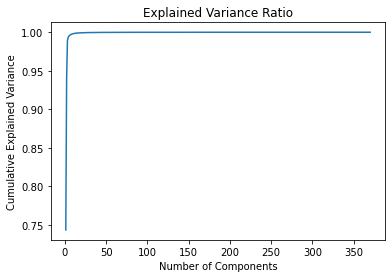



Closer Look


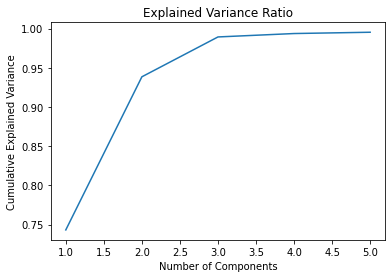

In [10]:
# Stadardization
scaler = StandardScaler()
data_std = scaler.fit_transform(data_with_datetime_index.T.values)

# PCA
pca=PCA()
pca.fit(data_std)

# Decide how many features we’d like to keep based on the cumulative variance plot
plt.plot(range(1, 371), pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Closer Look
print('\n\nCloser Look')
plt.plot(range(1, 6), pca.explained_variance_ratio_.cumsum()[:5])
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [11]:
# PCA
pca=PCA(n_components=3)
pca.fit(data_std)
pca_result = pca.transform(data_std)
pca_result = pd.DataFrame(pca_result, columns=['0', '1', '2'])

pca_result.head()

,0,1,2
0,-78.241293,14.899625,-4.968907
1,-75.507412,15.445048,-4.167743
2,-78.290995,14.864254,-5.414635
3,-65.479330,18.151775,-1.126192
4,-72.537530,16.235943,-3.276934


### K-Means (with k = 8)

In [12]:
kmeans_8 = TimeSeriesKMeans(n_clusters=8, metric="dtw", max_iter=10)
kmeans_8.fit(pca_result)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=8)

#### Results

In [23]:
# 3D scatterplot using plotly
Scene = dict(xaxis = dict())
labels = kmeans_8.labels_
trace = go.Scatter3d(x = pca_result['0'], y = pca_result['1'], z = pca_result['2'], 
                     mode = 'markers', marker = dict(color = labels, size = 10, 
                                                     line = dict(color = 'black', width = 10)))
layout = go.Layout(margin = dict(l = 0, r = 0), scene = Scene, height = 500, width = 500)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

### K-Means: Elbow Method

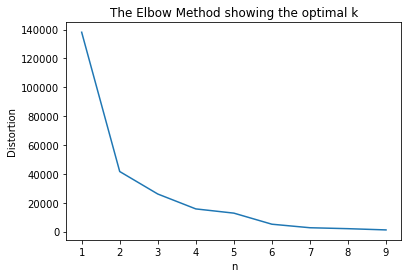

In [24]:
distortions = []
n = range(1, 10)
for k in n:
    kmeans_elbow = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
    kmeans_elbow.fit(pca_result)
    distortions.append(kmeans_elbow.inertia_)

plt.plot(n, distortions)
plt.xlabel('n')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### K-Means with optimal number of clusters (k = 2)

In [25]:
kmeans_2 = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=10)
kmeans_2.fit(pca_result)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=2)

#### Results

In [26]:
# 3D scatterplot using plotly
Scene = dict(xaxis = dict())
labels = kmeans_2.labels_
trace = go.Scatter3d(x=pca_result['0'], y=pca_result['1'], z=pca_result['2'], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 500,width = 500)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

### DBSCAN

#### Find optimum epsilon distance(eps)

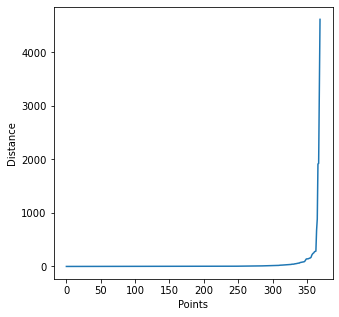

Closer Look


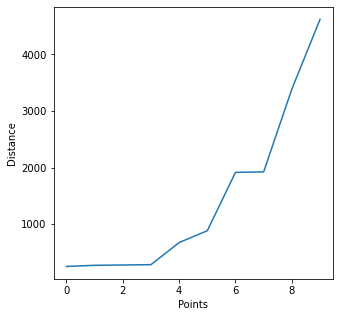

Optimal value of e: distances[365] -> 886


In [27]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(pca_result)

distances, indices = neighbors.kneighbors(pca_result)
distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

print("Closer Look")
fig = plt.figure(figsize=(5, 5))
plt.plot(distances[360:])
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

print("Optimal value of e: " + "distances[365] ->", int(distances[365]))

In [28]:
db = DBSCAN(eps=886, min_samples=8)
db.fit(pca_result.values)

DBSCAN(eps=886, min_samples=8)

#### Results

In [29]:
# 3D scatterplot using plotly
Scene = dict(xaxis = dict())
labels = db.labels_
trace = go.Scatter3d(x=pca_result['0'], y=pca_result['1'], z=pca_result['2'], 
                    mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 500,width = 500)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

## Prediction: Random Forest & LSTM

### Which Cluster of the K-Means (k = 2)?

In [30]:
print('Unique values: ')
print(set(kmeans_2.labels_))
print('\nCluster 0: ')
print(list(kmeans_2.labels_).count(0), 'clients')
print('\nCluster 1: ')
print(list(kmeans_2.labels_).count(1), 'clients')
print('\nSo, pick Cluster 1')

Unique values: 
{0, 1}

Cluster 0: 
367 clients

Cluster 1: 
3 clients

So, pick Cluster 1


In [31]:
# Pick the Cluster 1 --> Unique Customers
kmeans_2_labels = pd.DataFrame(kmeans_2.labels_)
clients_for_prediction = list(kmeans_2_labels[kmeans_2_labels[0]==1].index)
clients_for_prediction=['MT_' + str(client) for client in clients_for_prediction]
unique_customers = data_with_datetime_index[clients_for_prediction]
unique_customers.head()

,MT_195,MT_278,MT_361
datetime,,,
2011-01-01 00:15:00,54.568528,12.349154,0.0
2011-01-01 00:30:00,55.837563,12.717071,0.0
2011-01-01 00:45:00,55.837563,12.349154,0.0
2011-01-01 01:00:00,56.260575,11.981236,0.0
2011-01-01 01:15:00,56.260575,11.797277,0.0


### Plot the selected Cluster: unique_customers

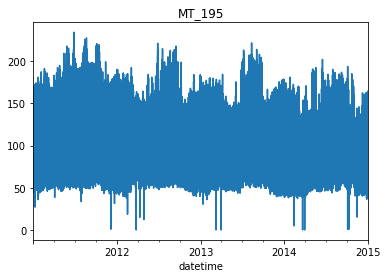

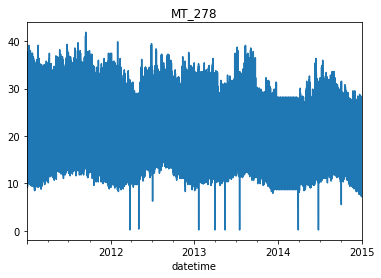

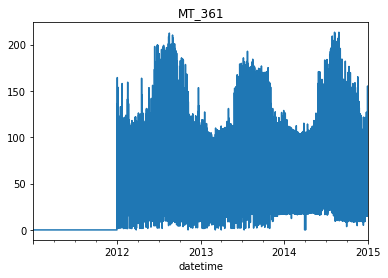

In [32]:
# Plot Customer Consumption
for i in unique_customers.columns.values:
    unique_customers[i].plot()
    plt.title(i)
    plt.show()

We observe that until "2012-01-01 00:00:00" the consumption of MT_361 are equal to zero. So we take the dataset after that time.

### Removing the datetimes before MT_361 start the consumption

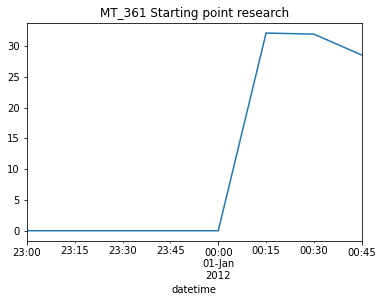

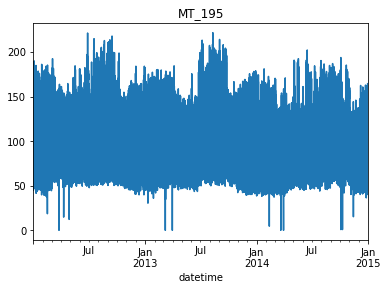

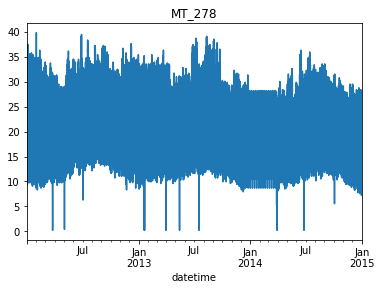

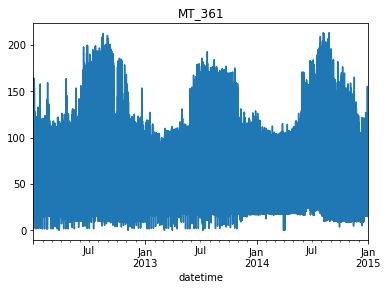

In [33]:
# Starting point research of MT_361 customer
unique_customers['MT_361']['2011-12-31 23:00:00':'2012-01-01 00:45:00'].plot()
plt.title('MT_361 Starting point research')
plt.show()

# Select prices after 2012-01-01 00:00:00
unique_customers = unique_customers['2012-01-01 00:15:00':]

# Plot Customer Consumption
for i in unique_customers.columns.values:
    unique_customers[i].plot()
    plt.title(i)
    plt.show()

### Trend Analysis




MT_195


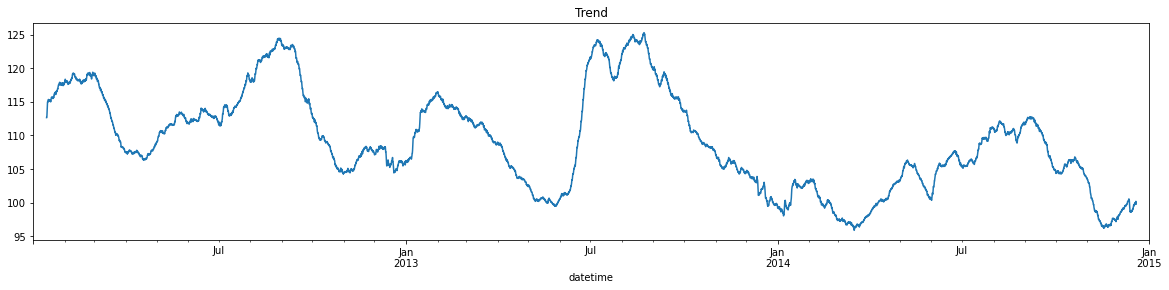

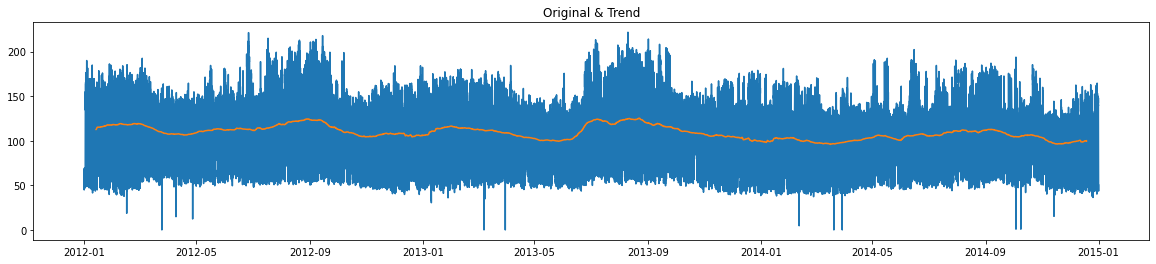




MT_278


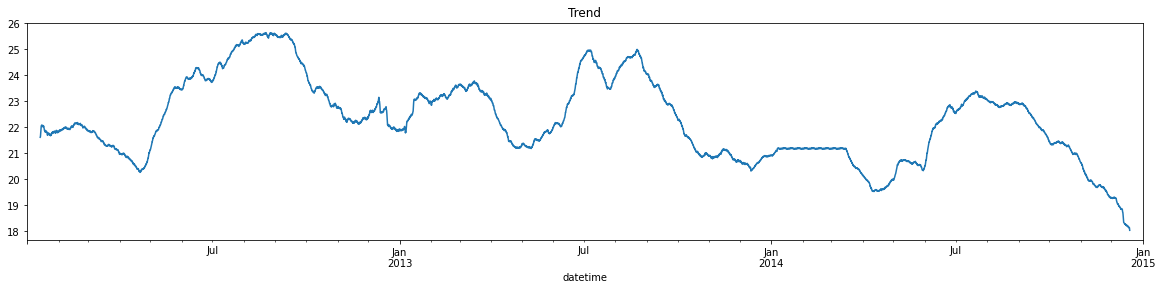

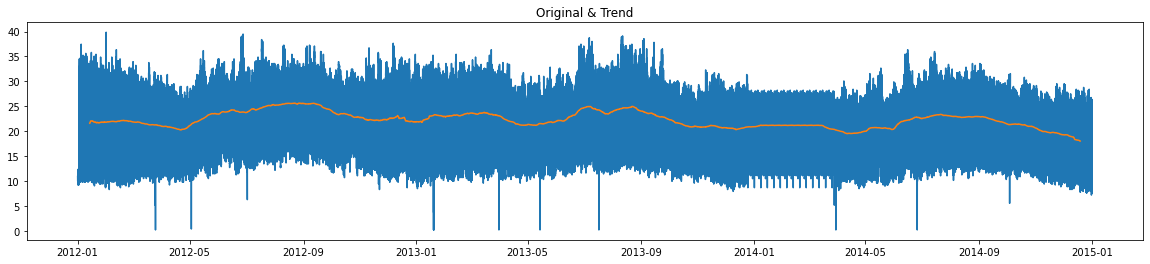




MT_361


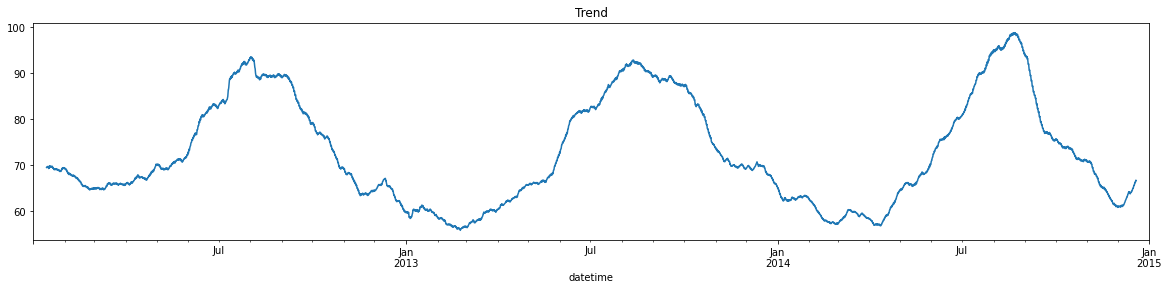

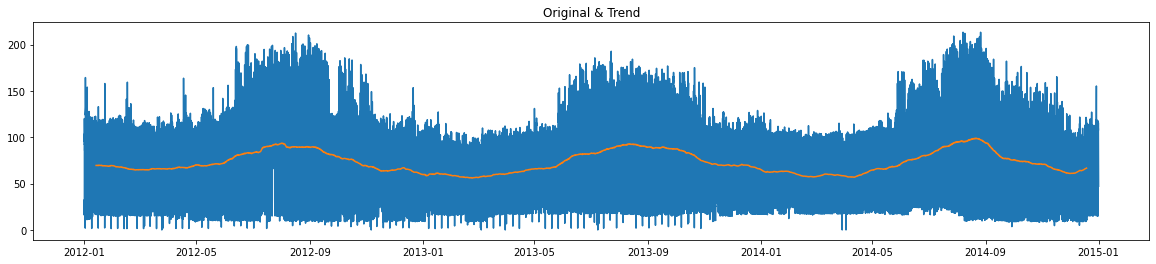

In [34]:
for i in unique_customers.columns.values:
    print("\n\n\n"+i)
    data_for_trending_analysis = unique_customers[i]
    decompose_result_mult = seasonal_decompose(data_for_trending_analysis, period=2500)

    decompose_result_mult.trend.plot(figsize=(20,4))
    plt.title('Trend')
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.plot(data_for_trending_analysis.loc['2012':])
    plt.plot(decompose_result_mult.trend)
    plt.title('Original & Trend')
    plt.show()

### Normalization (min-max)

In [35]:
unique_customers_max = unique_customers.max()
unique_customers_min = unique_customers.min()

norm_unique_customers = (unique_customers-unique_customers.min())/(unique_customers.max()-unique_customers.min())

### Detrending

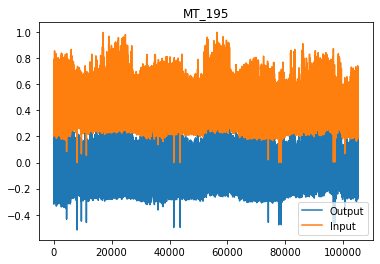

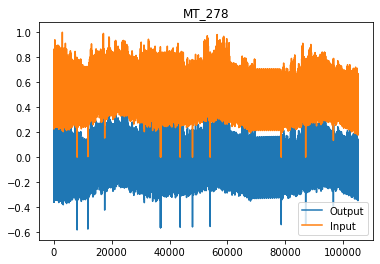

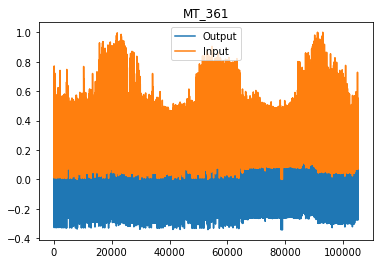

In [36]:
detrend_unique_customers = pd.DataFrame()

for i in norm_unique_customers.columns.values:
    tmp = signal.detrend(norm_unique_customers[i])
    plt.plot(signal.detrend(tmp))
    plt.plot(norm_unique_customers[i].values)
    plt.title(i)
    plt.legend(["Output", "Input"])
    plt.show()

    detrend_unique_customers[i] = pd.DataFrame(tmp, index=norm_unique_customers.index)

### Time Series Augmentation | Overlapping Windows

In [37]:
data_for_augmentation = detrend_unique_customers.copy()
data_for_augmentation.reset_index(inplace=True)

def data_augmentation(data_aug, window_size, overlap):
    num_windows = (len(data_aug) - window_size) // overlap + 1

    # Create a list to store the windows
    windows = []

    # Generate overlapping windows
    for i in range(num_windows):
        start_index = i * overlap
        end_index = start_index + window_size
        window = data_aug.iloc[start_index:end_index]
        windows.append(window)

    output=pd.DataFrame()
    # Concat the generated windows
    for window in windows:
        output = pd.concat([output, window], ignore_index=True)
    
    output.sort_values("datetime", inplace=True)

    return output

data_after_augmentation = data_augmentation(data_for_augmentation, 960, 96)
data_after_augmentation.set_index("datetime", inplace=True)

print("Data before Augmentation:", detrend_unique_customers.shape)
print("Data after Augmentation:", data_after_augmentation.shape)

data_for_prediction = data_after_augmentation.copy()

Data before Augmentation: (105216, 3)
Data after Augmentation: (1043520, 3)


### Split Data 
<ul>
<li>Train 70%</li>
<li>Validation 15%</li>
<li>Test 15%</li>
</ul>

In [38]:
# Split the data into train, validation, and test sets
train_size = 0.7  
val_size = 0.15  
test_size = 0.15  

# Calculate the number of samples for each set based on the ratios
num_samples = data_for_prediction.shape[0]
num_train = int(num_samples * train_size)
num_val = int(num_samples * val_size)
num_test = int(num_samples * test_size)

# Split the data based on the shuffled indices
train_data = data_for_prediction.iloc[:num_train]
val_data = data_for_prediction.iloc[num_train:num_train + num_val]
test_data = data_for_prediction.iloc [num_train + num_val:]

print('Total Rows:\t\t', num_samples, '\n')
print('Train Data:\t\t', train_data.shape)
print('Validation Data:\t', val_data.shape)
print('Test Data shape:\t', test_data.shape)

Total Rows:		 1043520 

Train Data:		 (730464, 3)
Validation Data:	 (156528, 3)
Test Data shape:	 (156528, 3)


### Define Input & Output
<ul>
<li>Input: 1h data (4 * 15m)</li>
<li>Output: the next 15m</li>
</ul>

In [39]:
# Define the number of time steps and features
n_steps = 4  # Number of time steps to consider

# Generate sequences of input data
def generate_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i + n_steps].values.T)
        y.append(data.iloc[i + n_steps].values)
    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

X_train, y_train = generate_sequences(train_data, n_steps)
X_val, y_val = generate_sequences(val_data, n_steps)
X_test, y_test = generate_sequences(test_data, n_steps)

# 3D to 2D for Random Forest
X_train_rm = X_train.reshape(X_train.shape[0], -1)
X_val_rm = X_val.reshape(X_val.shape[0], -1)
X_test_rm = X_test.reshape(X_test.shape[0], -1)

In [40]:
print('Input:', X_train_rm.shape)
print(X_train_rm[:3])
print('\n-----------------------------------------\n')
print('Output:', y_train.shape)
print(y_train[:3])

Input: (730460, 12)
[[-0.28862578 -0.27908322 -0.26572388 -0.2924409  -0.336081   -0.3128936
  -0.32680508 -0.33144182 -0.18598679 -0.18682368 -0.20272335 -0.2052339 ]
 [-0.27908322 -0.26572388 -0.2924409  -0.24091361 -0.3128936  -0.32680508
  -0.33144182 -0.33607858 -0.18682368 -0.20272335 -0.2052339  -0.20439716]
 [-0.26572388 -0.2924409  -0.24091361 -0.29816496 -0.32680508 -0.33144182
  -0.33607858 -0.33144063 -0.20272335 -0.2052339  -0.20439716 -0.20439725]]

-----------------------------------------

Output: (730460, 3)
[[-0.24091361 -0.33607858 -0.20439716]
 [-0.29816496 -0.33144063 -0.20439725]
 [-0.28480563 -0.33144003 -0.20439732]]


### Random Forest

In [41]:
# Create and train the Random Forest model
model_rm = RandomForestRegressor(n_estimators=100, random_state=42)
model_rm.fit(X_train_rm, y_train)

RandomForestRegressor(random_state=42)

In [42]:
# Make predictions on the validation set
y_val_pred = model_rm.predict(X_val_rm)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set:", mse)

# Make predictions on the test set
y_test_pred = model_rm.predict(X_test_rm)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set:", mse_test)

Mean Squared Error on the validation set: 0.00017425707790254358
Mean Squared Error on the test set: 0.0002320805657098409


### Results | Random Forest

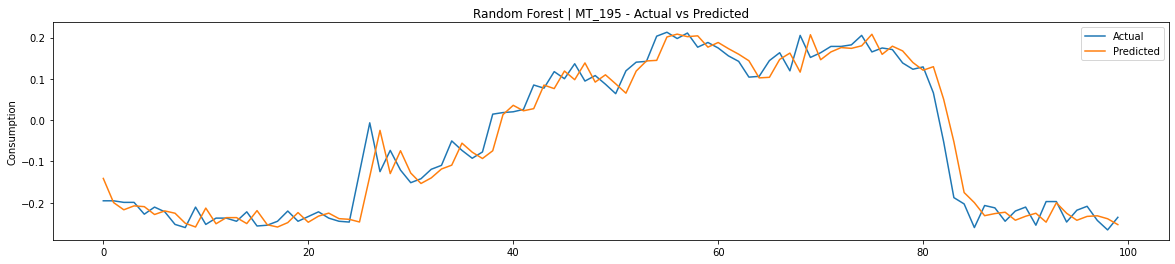

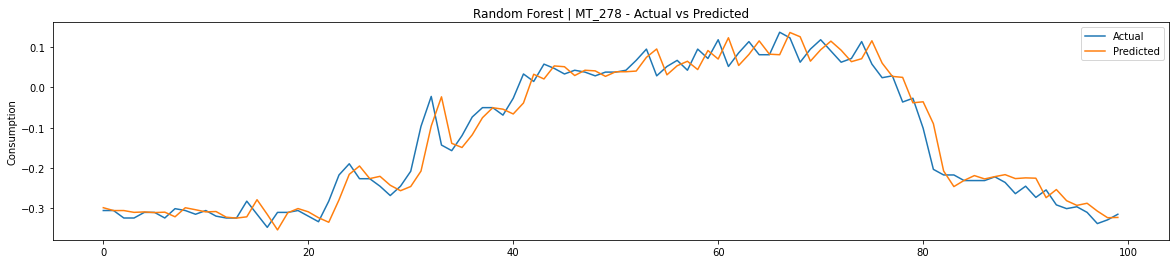

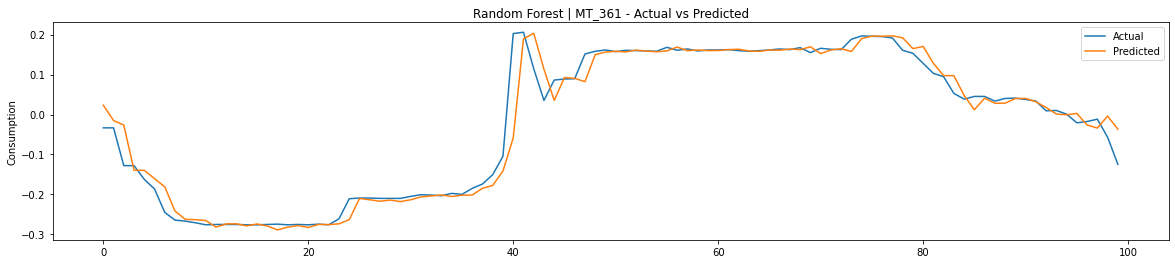

In [43]:
# Plot the results
for i in range(3):
    plt.figure(figsize=(20, 4))
    plt.plot(y_test[-100:, i], label='Actual')
    plt.plot(y_test_pred[-100:, i], label='Predicted')
    plt.ylabel('Consumption')
    plt.title('Random Forest | ' + data_for_augmentation.columns[i+1] +' - Actual vs Predicted')
    plt.legend()
    plt.show()

### LSTM

In [44]:
y_train_lstm = y_train.reshape((y_train.shape[0], 3, 1))
y_val_lstm = y_val.reshape((y_val.shape[0], 3, 1))
y_test_lstm = y_test.reshape((y_test.shape[0], 3, 1))

In [45]:
print('Input:', X_train.shape)
print(X_train[:3])
print('\n-----------------------------------------\n')
print('Output:', y_train_lstm.shape)
print(y_train_lstm[:3])

Input: (730460, 3, 4)
[[[-0.28862578 -0.27908322 -0.26572388 -0.2924409 ]
  [-0.336081   -0.3128936  -0.32680508 -0.33144182]
  [-0.18598679 -0.18682368 -0.20272335 -0.2052339 ]]

 [[-0.27908322 -0.26572388 -0.2924409  -0.24091361]
  [-0.3128936  -0.32680508 -0.33144182 -0.33607858]
  [-0.18682368 -0.20272335 -0.2052339  -0.20439716]]

 [[-0.26572388 -0.2924409  -0.24091361 -0.29816496]
  [-0.32680508 -0.33144182 -0.33607858 -0.33144063]
  [-0.20272335 -0.2052339  -0.20439716 -0.20439725]]]

-----------------------------------------

Output: (730460, 3, 1)
[[[-0.24091361]
  [-0.33607858]
  [-0.20439716]]

 [[-0.29816496]
  [-0.33144063]
  [-0.20439725]]

 [[-0.28480563]
  [-0.33144003]
  [-0.20439732]]]


In [46]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(16, activation='sigmoid', input_shape=(3, 4)))
model_lstm.add(Dense(3))
model_lstm.compile(optimizer='adam', loss='mse')

2023-06-06 23:10:39.979134: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-06 23:10:39.987236: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
history = model_lstm.fit(X_train, y_train_lstm, epochs=20, batch_size=500, 
                         validation_data=(X_val, y_val_lstm))

2023-06-06 23:10:40.274584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
1461/1461 [==============================] - 5s 3ms/step - loss: 0.0175 - val_loss: 0.0010
Epoch 2/20
1461/1461 [==============================] - 4s 3ms/step - loss: 9.6341e-04 - val_loss: 2.8853e-04
Epoch 3/20
1461/1461 [==============================] - 4s 3ms/step - loss: 3.3316e-04 - val_loss: 2.3587e-04
Epoch 4/20
1461/1461 [==============================] - 4s 3ms/step - loss: 2.6773e-04 - val_loss: 1.8814e-04
Epoch 5/20
1461/1461 [==============================] - 4s 3ms/step - loss: 2.1853e-04 - val_loss: 1.6748e-04
Epoch 6/20
1461/1461 [==============================] - 4s 3ms/step - loss: 1.9899e-04 - val_loss: 1.5954e-04
Epoch 7/20
1461/1461 [==============================] - 4s 3ms/step - loss: 1.8737e-04 - val_loss: 1.6326e-04
Epoch 8/20
1461/1461 [==============================] - 4s 3ms/step - loss: 1.8927e-04 - val_loss: 1.5942e-04
Epoch 9/20
1461/1461 [==============================] - 4s 3ms/step - loss: 1.8660e-04 - val_loss: 1.5879e-04
Epoch 10/20
1461/1

In [48]:
# Make predictions
predictions = model_lstm.predict(X_test)

lstm_mse = mean_squared_error(y_test_lstm.reshape((y_test_lstm.shape[0], -1)), predictions.reshape((predictions.shape[0], -1)))
# Print the mean squared error
print('Mean Squared Error:', lstm_mse)

Mean Squared Error: 0.00019785551


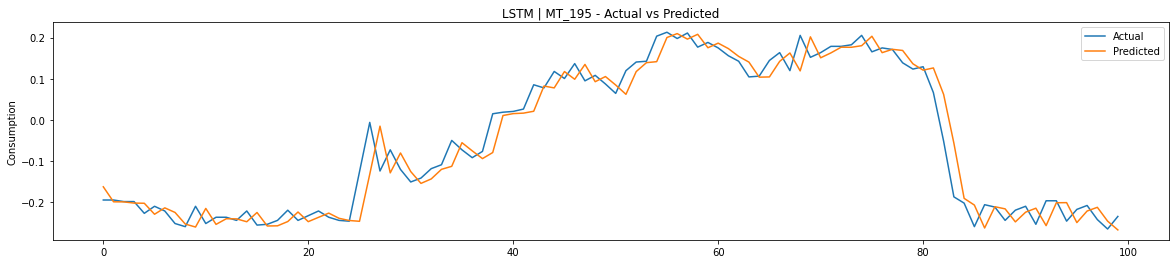

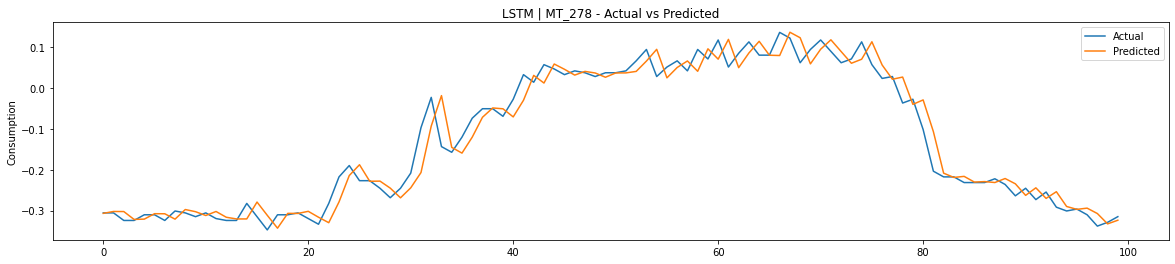

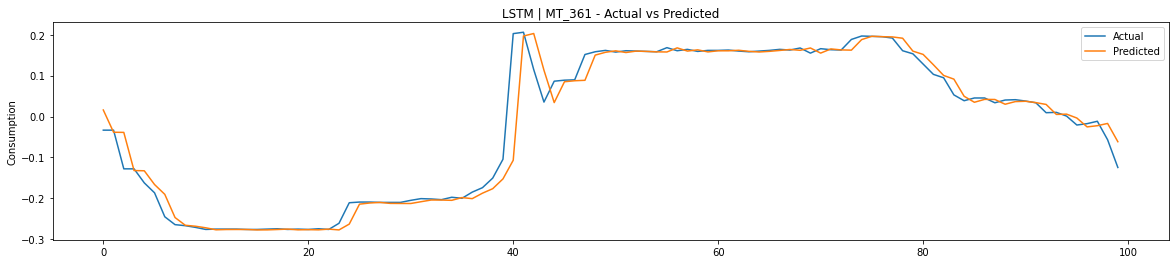

In [49]:
# Plot the results
for i in range(3):
    plt.figure(figsize=(20, 4))
    plt.plot(y_test_lstm.reshape((y_test_lstm.shape[0], -1))[-100:, i], label='Actual')
    plt.plot(predictions.reshape((predictions.shape[0], -1))[-100:, i], label='Predicted')
    plt.ylabel('Consumption')
    plt.title('LSTM | ' + data_for_augmentation.columns[i+1] +' - Actual vs Predicted')
    plt.legend()
    plt.show()

## Consumption Improvements: Hourly

### Mean Hourly Consumption

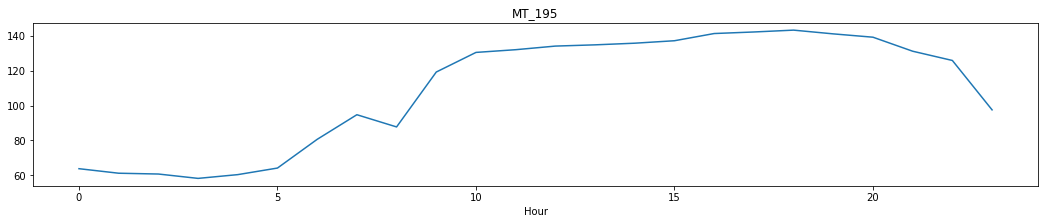

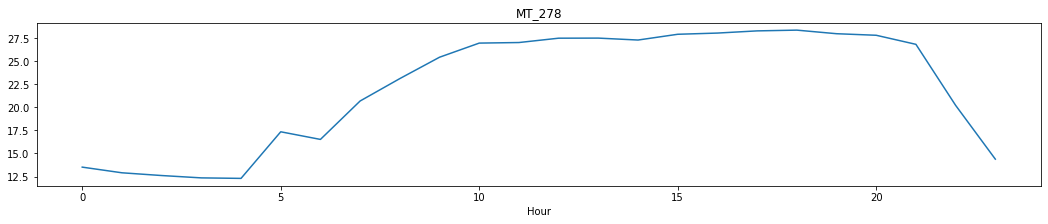

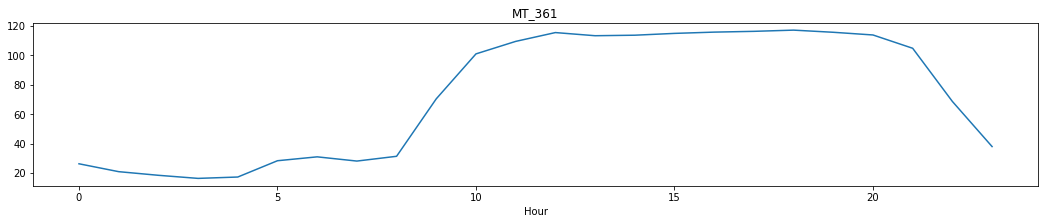

In [50]:
datal = unique_customers.copy()
datal['hour'] = datal.index.hour
for i in range(3):
    plt.figure(figsize=(18, 3))
    plt.plot(datal[datal.columns[i]].groupby(datal['hour']).mean())
    plt.title(datal.columns[i])
    plt.xlabel('Hour')
    plt.show()